In [1]:
import numpy as np
import torch
from connectivity_representation_learning import *

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # unused import, required by projection='3d'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Generate 2D Gaussian mixture data

In [14]:
# dimension
d = 2
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [15]:
input_size = data.shape[1]
hidden_size = 20
emb_size = 2
use_cuda = False
eta = 2.0
tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [16]:
model_no_penalty = Model(input_size, 
                         hidden_size,
                         emb_size,
                         hidden_size,
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)
torch.save(model_no_penalty.state_dict(), 'gauss_2d_{}_epochs_no_penalty.pt'.format(n_epochs))

model_penalty = Model(input_size, 
                      hidden_size,
                      emb_size,
                      hidden_size,
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)
torch.save(model_penalty.state_dict(), 'gauss_2d_{}_epochs_penalty.pt'.format(n_epochs))

Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 376it/s, connectivity loss=0, reconstruction loss=2.29]
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 420it/s, connectivity loss=0, reconstruction loss=1.82]
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 457it/s, connectivity loss=0, reconstruction loss=1.24]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 423it/s, connectivity loss=0, reconstruction loss=0.688]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 452it/s, connectivity loss=0, reconstruction loss=0.402]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 391it/s, connectivity loss=0, reconstruction loss=0.269]
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 399it/s, connectivity loss=0, reconstruction loss=0.21] 
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 432it/s, connectivity loss=0, reconstruction loss=0.178]
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 441it/s, connectivity loss=0, reconstruction loss=0.144]
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 414it/s, connectivity loss=0,

### Results

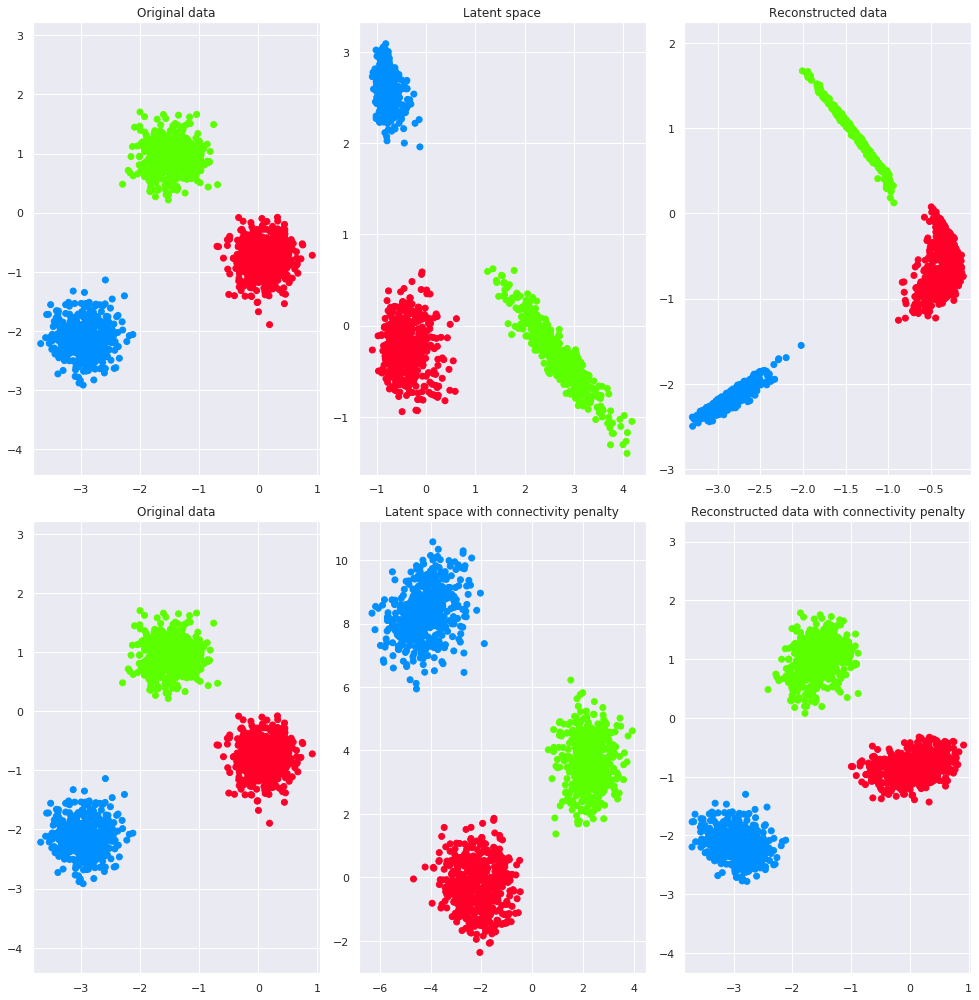

[0.00012978344, 0.03615087433982549, 0.3419867]
[0.00023058633, 0.03015647638457253, 0.27678958]
[0.0003717377, 0.0928303818280831, 0.48067257]


In [17]:
fig, axes = plt.subplots(figsize=(14, 14), nrows=2, ncols=3)

ax = axes[0, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[0, 1]
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data')


ax = axes[1, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[1, 1]
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')

ax = axes[1, 2]
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty')

plt.tight_layout()
plt.show()

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))

### Generate 3D Gaussian mixture data

In [18]:
# dimension
d = 3
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [19]:
input_size = data.shape[1]
hidden_size = 20
emb_size = 2
use_cuda = False
eta = 2.0
tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [20]:
model_no_penalty = Model(input_size, 
                         hidden_size,
                         emb_size,
                         hidden_size,
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)
torch.save(model_no_penalty.state_dict(), 'gauss_3d_{}_epochs_no_penalty.pt'.format(n_epochs))

model_penalty = Model(input_size, 
                      hidden_size,
                      emb_size,
                      hidden_size,
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)
torch.save(model_penalty.state_dict(), 'gauss_3d_{}_epochs_penalty.pt'.format(n_epochs))

Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 367it/s, connectivity loss=0, reconstruction loss=12.2]
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 405it/s, connectivity loss=0, reconstruction loss=10.1]
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 481it/s, connectivity loss=0, reconstruction loss=6.93]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 407it/s, connectivity loss=0, reconstruction loss=4.57]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 446it/s, connectivity loss=0, reconstruction loss=3.68]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 378it/s, connectivity loss=0, reconstruction loss=2.54]
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 380it/s, connectivity loss=0, reconstruction loss=0.902]
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 412it/s, connectivity loss=0, reconstruction loss=0.211]
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 444it/s, connectivity loss=0, reconstruction loss=0.13] 
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 461it/s, connectivity loss=0, re

### Results

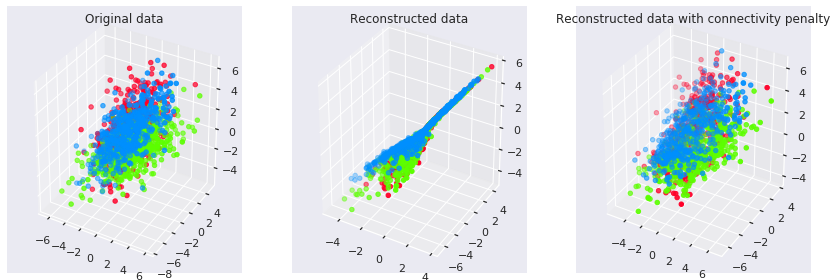

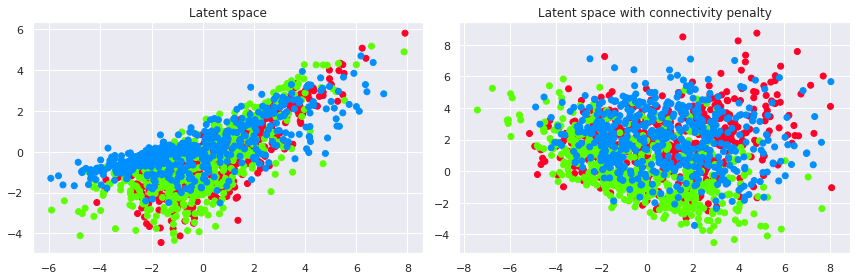

[0.025195591, 0.30619705678693926, 0.499367]
[0.0017988994, 0.1040483929967461, 0.47964394]
[0.005199917, 0.15111524348598393, 0.49735326]


In [9]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(data[:, 0], data[:, 1],  data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Original data')

ax = fig.add_subplot(132, projection='3d')
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1],  reconstructed_data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Reconstructed data')

ax = fig.add_subplot(133, projection='3d')
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1],  reconstructed_data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Reconstructed data with connectivity penalty')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')

ax = fig.add_subplot(122)
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')

plt.tight_layout()
plt.show()

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))